In [ ]:
%load core.py

/home/lachlan/.pyenv/versions/venv_readoutxfm/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


script: /home/lachlan/CODEBASE/ReadoutXFM/config.py
script path: /home/lachlan/CODEBASE/ReadoutXFM
data path: /home/lachlan/CODEBASE/ReadoutXFM/data
---------------
opening .geo: geo2
---------------------------
EXTRACTING SPECTRA
---------------------------

stream length in bytes: 195154338
first two bytes: b'\xd4\x05'
header length: 1492
pixels expected (X*Y): 9677
---------------------------
EXTRACTING SPECTRA
---------------------------
pixels expected (X*Y): 9677
---------------------------
Pixel 0 at 1494 bytes, 0.0 %
Pixel 100 at 852658 bytes, 0.4 %
Pixel 200 at 1536670 bytes, 0.8 %
Pixel 300 at 2369206 bytes, 1.2 %
Pixel 400 at 3113538 bytes, 1.6 %
Pixel 500 at 3852734 bytes, 2.0 %
Pixel 600 at 4705338 bytes, 2.4 %
Pixel 700 at 5344266 bytes, 2.7 %
Pixel 800 at 6164014 bytes, 3.2 %
Pixel 900 at 6916446 bytes, 3.5 %
Pixel 1000 at 7605586 bytes, 3.9 %
Pixel 1100 at 8456022 bytes, 4.3 %
Pixel 1200 at 9071382 bytes, 4.6 %
Pixel 1300 at 9863462 bytes, 5.1 %
Pixel 1400 at 10631958 b

ValueError: cannot reshape array of size 9677 into shape (256)

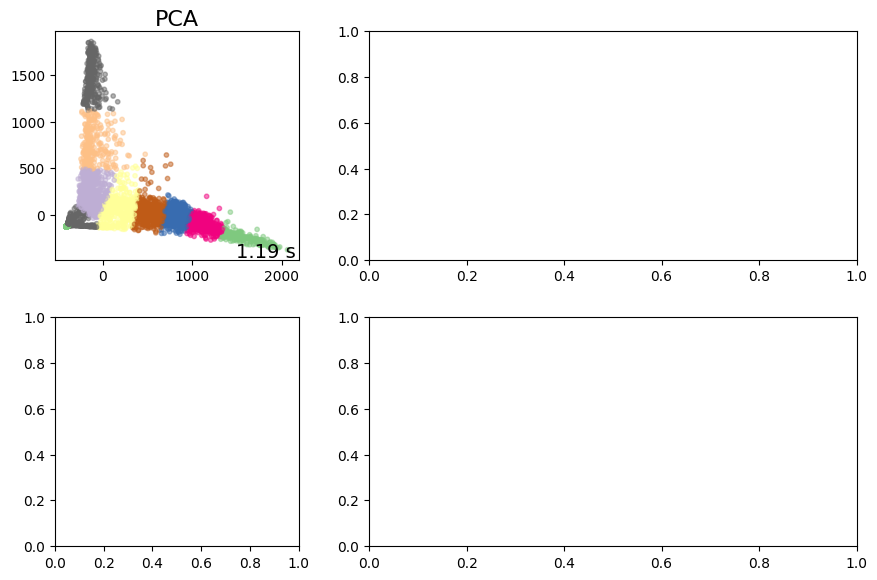

In [1]:
# %load core.py
import os
import time
import gc
import time

import numpy as np
from sklearn import decomposition
import umap.umap_ as umap

import config
import src.utils as utils
import src.bitops as bitops
import src.colour as colour
import src.clustering as clustering

"""
INITIALISE data TO WHOLE MAP EVEN IF USING EARLY STOP
.: huge memory req
can scale that down

also consider throwing away some, scaling down floats/ints etc

"""


"""
Parses spectrum-by-pixel maps from IXRF XFM

- parses binary .GeoPIXE files
- extracts pixel parameters
- projects spectra onto simple RGB channels
- displays as RGB

./data has example dataset

SPEED
                t/px
reading only:   0.00014 
colourmap:      0.0078
read and clust  0.001296 

"""

#-----------------------------------
#CLASSES
#-----------------------------------
"""
reducers = [
    (manifold.TSNE, {"perplexity": 50}),
    # (manifold.LocallyLinearEmbedding, {'n_neighbors':10, 'method':'hessian'}),
    (manifold.Isomap, {"n_neighbors": 30}),
    (manifold.MDS, {}),
    (decomposition.PCA, {}),
    (umap.UMAP, {"n_neighbors": 30, "min_dist": 0.3}),
]
"""
reducers = [
    (decomposition.PCA, {}),
    (umap.UMAP, {"n_neighbors": 30, "min_dist": 0.3}),
]

#-----------------------------------
#INITIALISE
#-----------------------------------

starttime = time.time()             #init timer
totalpx=config.MAPX*config.MAPY     #map size
chan=np.arange(0,config.NCHAN)      #channels
energy=chan*config.ESTEP            #energy list

#   if we are skipping some of the file
#       assign the ratio and adjust totalpx
if config.SHORTRUN:
    skipratio=config.shortpct/100
    totalpx=int(np.ceil(totalpx*skipratio))

#-----------------------------------
#MAIN START
#-----------------------------------

#check filetype is recognised - currently only accepts .GeoPIXE
if config.FTYPE == ".GeoPIXE":
    f = os.path.join(config.wdir,config.infile)
    fname = os.path.splitext(os.path.basename(f))[0]

    print("opening .geo:",fname)
else: 
    print(f'FATAL: filetype {config.FTYPE} not recognised')
    exit()

print(
    "---------------------------\n"
    "EXTRACTING SPECTRA\n"
    "---------------------------\n"
)

#open the datafile 
with open(f, mode='rb') as file: # rb = read binary
    
    #generate bytestream
    stream = file.read()         #NB. to read in chunks, add chunk size as read(SIZE)
    streamlen=len(stream)

    print(f"stream length in bytes: {streamlen}")
    print(f"first two bytes: {stream[:2]}")

    headerlen=bitops.binunpack(stream,0,"<H")[0]
    print(f"header length: {headerlen}")
    print(f"pixels expected (X*Y): {totalpx}")


    #check for missing header
    #   pixels start with "DP" (=20550 as <uint16)
    #   if we find this immediately, header is zero length
    if headerlen == 20550:
        print("WARNING: no header found")
        headerlen=0
    
    #assign starting pixel index 
    idx=headerlen+2 #legnth of header + 2 bytes

    #initialise pixel param arrays
    pxlen=np.zeros(totalpx)
    xidx=np.zeros(totalpx)
    yidx=np.zeros(totalpx)
    det=np.zeros(totalpx)
    dt=np.zeros(totalpx)
    
    if config.DOCOLOURS == True:
        #initalise pixel colour arrays
        rvals=np.zeros(totalpx)
        gvals=np.zeros(totalpx)
        bvals=np.zeros(totalpx)
        totalcounts=np.zeros(totalpx)

    #initialise data array
    data=np.zeros((totalpx,config.NCHAN))


    print(
        "---------------------------\n"
        "EXTRACTING SPECTRA\n"
        "---------------------------\n"
        f"pixels expected (X*Y): {totalpx}\n"
        "---------------------------"
    )

    i=0 #pixel counter

    #loop through pixels
    while idx < streamlen:

        #print pixel index every 100 px
        if i % 100 == 0: print(f"Pixel {i} at {idx} bytes, {100*idx/streamlen:.1f} %")

        #read pixel record into spectrum and header param arrays, 
        # + reassign index at end of read
        outchan, counts, pxlen[i], xidx[i], yidx[i], det[i], dt[i], idx = bitops.readpxrecord(idx, stream)

        #fill gaps in spectrum 
        #   (ie. add 0s for all missing chans)
        outchan, counts = utils.gapfill(outchan,counts, config.NCHAN)

        #warn if recieved channel list is different length to chan array
        if len(outchan) != len(chan):
            print("WARNING: unexpected length of channel list")
      
        #assign counts into data array - 
        data[i,:]=counts

        #build colours if required
        if config.DOCOLOURS == True: rvals[i], bvals[i], gvals[i], totalcounts[i] = colour.spectorgb(energy, counts)
        
        #warn if i is unexpectedly high - would mostly happen if header is wrong
        if i > totalpx:
            print(f"WARNING: pixel count {i} exceeds expected map size {totalpx}")

        if (config.SHORTRUN == True) and (idx > streamlen*(skipratio)):
            print("ending at:", idx)
            idx=streamlen+1
        i+=1

    runtime = time.time() - starttime

    print(
        "---------------------------\n"
        "MAP COMPLETE\n"
        "---------------------------\n"
        f"pixels expected (X*Y): {totalpx}\n"
        f"pixels found: {i}\n"
        f"total time: {round(runtime,2)} s\n"
        f"time per pixel: {round((runtime/i),6)} s\n"
        "---------------------------"
    )

    #clear the bytestream from memory
    del stream
    gc.collect()

    if config.DOCOLOURS == True:
        rgbarray=colour.clcomplete(rvals, gvals, bvals, totalcounts)
        colour.clshow(rgbarray)

    print("DOCLUST", config.DOCLUST)
    if config.DOCLUST:
        embedding, clusttimes = clustering.reduce(data)
        categories = clustering.dokmeans(embedding, totalpx)
        print("categories full")
        print(categories)
        print(categories.shape)

        clustaverages=np.zeros([len(clustering.reducers),config.nclust,config.NCHAN])
        for i in range(len(clustering.reducers)):
            redname=clustering.getredname(i)
            clustaverages[i]=clustering.sumclusters(data, categories[i])
            
            for j in range(config.nclust):
                print(f'saving reducer {redname} cluster {j} with shape {clustaverages[i,j,:].shape}')
                np.savetxt(os.path.join(config.odir, "sum_" + redname + "_" + str(j) + ".txt"), np.c_[energy, clustaverages[i,j,:]], fmt=['%1.3e','%1.6e'])
            
            print(f'saving combined file for {redname}')
            np.savetxt(os.path.join(config.odir, "sum_" + redname + ".txt"), np.c_[energy, clustaverages[i,:,:].transpose(1,0)], fmt='%1.5e')             
            #plt.plot(energy, clustaverages[i,j,:])
        clustering.clustplt(embedding, categories, config.MAPX, clusttimes)

    np.savetxt(os.path.join(config.odir, "pxlen.txt"), pxlen)
    np.savetxt(os.path.join(config.odir, "xidx.txt"), xidx)
    np.savetxt(os.path.join(config.odir, "yidx.txt"), yidx)
    np.savetxt(os.path.join(config.odir, "detector.txt"), det)
    np.savetxt(os.path.join(config.odir, "dt.txt"), dt)

print("CLEAN EXIT")
exit()


"""
snip background
https://stackoverflow.com/questions/57350711/baseline-correction-for-spectroscopic-data
"""

In [4]:
#%load core.py
print(data.shape[0])

9676
